# Multichannel Image Reconstruction with Noise
Objectives:
1. Show effect of noise in multichannel images (RMS and SENSE)
1. Provide a template for understanding noise measurement

Summary of Steps:
1.  Generate image data, coil sensitivities and coil images
1.  Generate noise from covariance matrix
1.  Calculate SENSE coil combination weights
1.  Calculate _analytic_ g-factor and SNR maps
1.  Add noise and reconstruct (repeating N times)
1.  Calculate mean and standard deviation "images," and measured g-factor and SNR




## Generate Image Data and Coil Sensitivities
The image here is a simple array of shapes.  Coil sensitivities are 2D gaussian, for simplicity.  We generate the sensitivities based on a center and scaling, both of which are arbitrary.  The initial goal is to support reduction factors $R=$ 1,2 or 3.  We display the basic image, coil sensitivities and coil images (which are the product of the basic image and coil sensitivities).


Start
cims pixel [8.16076174+0.j 6.13935106+0.j 0.44704215+0.j 0.74735642+0.j]


/Users/brian/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


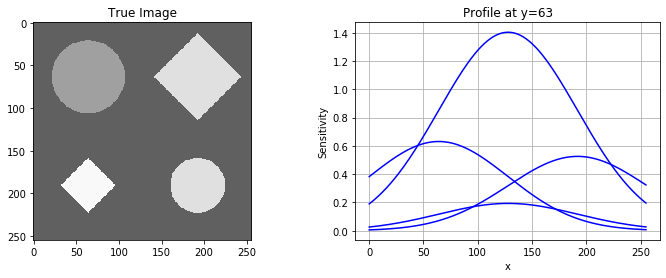

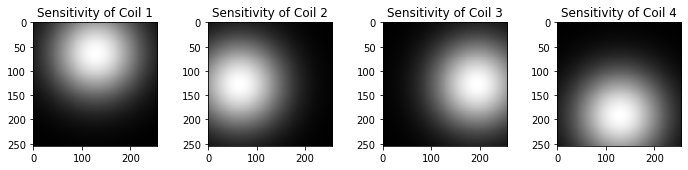

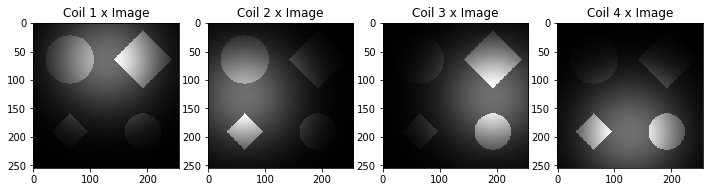

In [36]:
# -- Initialization
import numpy as np
import matplotlib.pyplot as plt
import mrsigpy as mrs
from scipy import signal as sig

%matplotlib inline

# -- Parameter Setup
print("Start")
R=3          # Reduction factor
Nx = 256     # Pixels along x
Ny = 256     # Pixels along y
Ny = (Ny//R)*R
Nc = 4       # Number of coils (channels)
x = np.arange(0,Nx)
y = np.arange(0,Ny)


# -- Generate image data
im = 10.0*mrs.diamond(   width=Nx/2.5,nx=Nx,ny=Ny,cx=Nx//4, cy=-Ny//4) 
im = im + 5.0*mrs.circ(  radius=Nx/6.0,nx=Nx,ny=Ny,cx=-Nx//4,cy = -Ny//4)
im = im + 10.0*mrs.circ( radius=Nx/8.0,nx=Nx,ny=Ny,cx=Nx//4,cy= Ny//4)
im = im + 12.0*mrs.diamond(width=Nx/4,nx=Nx,ny=Ny,cx=-Nx//4, cy=Ny//4) 

plt.figure(figsize=(12.,4.))
plt.subplot(1,2,1)
plt.imshow(im,cmap='gray',vmin=0.0,vmax=20.0)
plt.title('True Image')
plt.show

# -- Generate Coil Sensitivities
csens = np.zeros((Ny,Nx,Nc),dtype='complex64')
# -- "diamond" arrangement
cx = np.array([0.5,0.25,0.75,0.5])  # -- x centers
cy = np.array([0.25,0.5,0.5,0.75])  # -- y centers

# -- "square arrangement"
#cx = np.array([0.25,0.75,0.25,0.75])
#cy = np.array([0.25,0.25,0.75,0.75])
csc= np.array([1.2, 0.9, 0.75, 1.25])   # Scale factors


for c in range(0,Nc):
  csens[:,:,c] = csc[c]*mrs.gaussian(y,Ny*cy[c],Ny/(1.0*Nc),x,Nx*cx[c],Nx/(1.0*Nc))
csens = 30000 * csens       # -- 30000 is roughly normalizing .

# Plot a line profile
plt.subplot(1,2,2)
plt.plot(x,csens[Ny//4,:,:],'b-')
tt = "Profile at y=%d" % (Ny//4)
mrs.lplot('x','Sensitivity',tt)
plt.show

# -- Plot sensitivities
plt.figure(figsize=(12.,5.))
for c in range(0,Nc):
  plt.subplot(2,Nc,Nc+c+1)
  plt.imshow(np.abs(csens[:,:,c]), cmap='gray',vmin=0.0)
  tt = "Sensitivity of Coil %d" % (c+1)
  plt.title(tt)





# -- Generate Coil Images with exact sensitivities
cims = csens * np.expand_dims(im,axis=2)

# -- Plot coil images
plt.figure(figsize=(12.,5.))
for c in range(Nc):
    plt.subplot(1,Nc,c+1)
    plt.imshow(abs(cims[:,:,c]),cmap='gray',vmin=0.0)
    tt = "Coil %d x Image" % (c+1)
    plt.title(tt)
plt.show

print("cims pixel",cims[50,50,:])


# Optional Section - Measured Sensitivities 

The basic approach to calculating the coil sensitivities is to use low-resolution images, normalized by the RMS image over all coils.  Here we calculate <code>msens</code> which means measured sensitivity.  You can use that instead of <code>csens</code> which is the _actual_ sensitivity.



RMS of Sensitivities


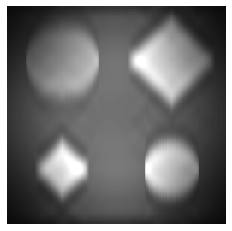

Measured vs Actual Sensitivities


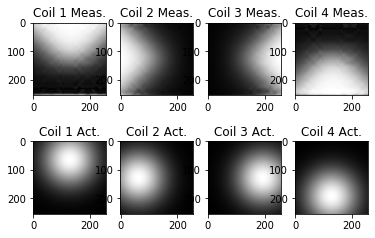

In [37]:
# -- Calculate coil sensitivities from low-resolution images
Ncal = 16
msens = 0*cims              # Measured Sensitivities

# -- Calculate the low-pass filtered images 
for c in range(Nc):
    fullim = cims[:,:,c]                            # Extract image for coil
    fullk = mrs.ift(fullim)                         # Transform to k-space
    subk = mrs.zpadcrop(fullk,Ncal)                 # Crop to keep central k-space
    subk = mrs.zpadcrop(subk,(Ny,Nx))               # Zero-pad back to full size
    #imlow = np.reshape(mrs.ft(subk),(Ny,Nx,1))     
    imlow = mrs.ft(subk)                            # Fourier transform back to image.
    msens[:,:,c]=imlow                              # Store sensitivity.

# -- Calculate the RMS of the low-pass filtered images.
rmsall = np.conj(msens)*msens              # Magnitude squared
rmssens = np.sqrt(np.sum(rmsall,axis=2))   # Root Sum of squares

# -- Display the RMS, add a small "epsilon" to avoid divide-by-zero
print("RMS of Sensitivities")
mrs.dispim(rmssens)
rmssens = np.reshape(rmssens,(Ny,Nx,1))
msens = msens/(rmssens+.0001)              # Normalize all by RMS.

# -- Show the measured vs actual sensitivities.
print("Measured vs Actual Sensitivities")
for c in range(Nc):
    plt.subplot(2,Nc,c+1)   
    plt.imshow(abs(msens[:,:,c]),cmap='gray',vmin=0.0)    # Actual
    tt = "Coil %d Meas." % (c+1)
    plt.title(tt)

    plt.subplot(2,Nc,Nc+c+1)
    plt.imshow(abs(csens[:,:,c]),cmap='gray',vmin=0.0)
    tt = "Coil %d Act." % (c+1)
    plt.title(tt)




# Optional Section - Noise Measurement

A way to measure th noise covariance is to take sample noise vectors into a matrx $N$ that is $N_c \times N_s$.  Then the noise covariance can be written as $\Psi = \frac{1}{2N_s} N N^H$.

This example makes random noise from a covariance matrix $\Psi$, for $N_c$ channels, then "measures" the covariance of that noise to show that it is close!  You can use the second step to measure noise from image data in different ways.

_Try adding elements to the covariance matrix_

In [ ]:
# -- Make random noise from covariance (similar to next section)

Psi = np.eye(4)             # Noise covariance (start with just diagonal)
Psi[1][2]=0.5               # Modify an element
Psi[2][1]=0.5               # Keep this positive-semidefinite
mrs.show_matrix(Psi)
# -- test noise
tnoise = np.random.multivariate_normal(np.zeros(Nc),Psi,(Ny*Nx)) + 1j*np.random.multivariate_normal(np.zeros(Nc),Psi,(Ny*Nx))

tnoise = np.reshape(tnoise,(Ny*Nx,Nc),order='F')  # (Ny Nx) x Nc
print("Shape of tnoise",np.shape(tnoise)) 

# -- Calculate covariance from test noise
Psi_calc = (0.5/Nx/Ny) * np.matmul(tnoise.conj().T,tnoise)

# -- Show output to compare to starting covariance
mrs.show_matrix(Psi_calc,"Measured Covariance")



1.00 0.00 0.00 0.00
0.00 1.00 0.50 0.00
0.00 0.50 1.00 0.00
0.00 0.00 0.00 1.00
Shape of tnoise (65280, 4)

Measured Covariance
0.99+0.00j -0.00+0.00j 0.00+0.00j 0.00-0.00j
-0.00-0.00j 1.01+0.00j 0.50-0.00j -0.01-0.00j
0.00-0.00j 0.50+0.00j 1.00+0.00j -0.00-0.00j
0.00+0.00j -0.01+0.00j -0.00+0.00j 0.99+0.00j


## SENSE Weight and Noise Calculation
Based on the reduction factor $R$, coil sensitivies and noise covariance matrix $\Psi$, we can calculate the SENSE combination weight matrix $W$, the g-factor (map) and the noise map.  The procedure is as follows:

1. Reduction factor $R$ (Set previously so $N_y$ is a multple of $R$).
1. Setup noise covariance matrix $\Psi$.
1. Re-organize sensitivities to include the aliased pixel dimpension in the last dimension, or 1 if $R=1$.

For a 2D image, the aliasing may be in x, y or a combination.  The SENSE algorithm does its best to unalias pixels given the coil sensitivities at aliased pixels.  Therefore, it is up to the calling code to put the sensitivity matrix of size $N_y \times N_x \times N_c \times R$.

SENSE Weight Calc - 21760 pts, 4 coils, R=3
SENSE weights has size (85, 256, 3, 4)
gfactor has size (85, 256, 3)
calcnoise has size (85, 256, 3)


<function matplotlib.pyplot.show(*args, **kw)>

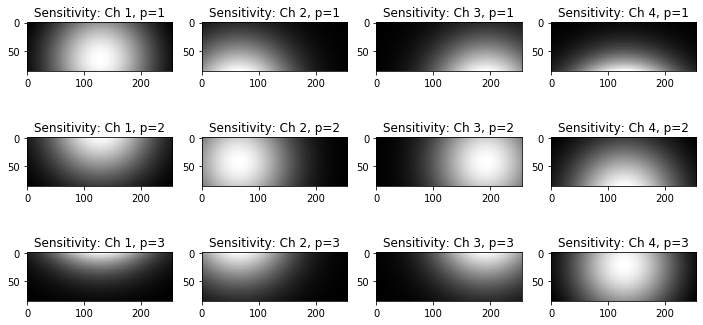

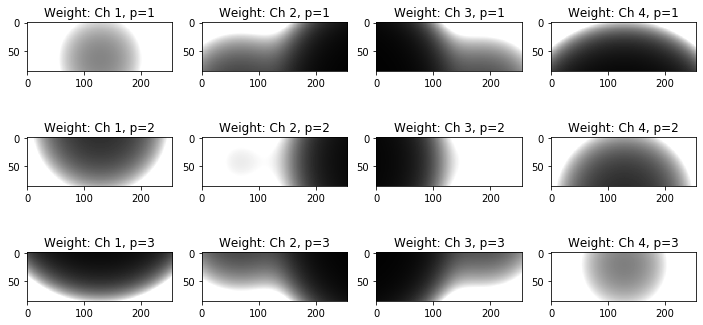

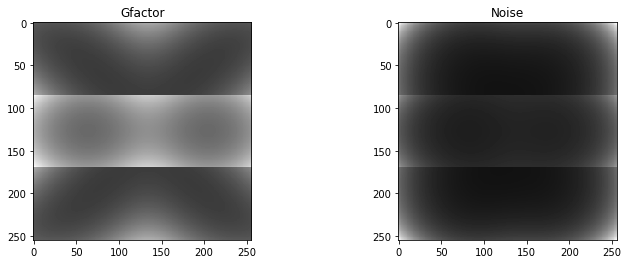

In [38]:
# -- Setup Full SENSE Problem
Psi = np.eye(4)   # Noise covariance (just diagonal)

# -- Coil Sensitivity for different R:   Ny x Nx x Nc x R
#    As R increases, decrease FOV, but increase last dimension

# --%% (replace csens with msens for measured vs actual sensitivity)
csens = np.reshape(csens,(Ny,Nx,Nc,1),order='F')     # -- Make correct # dimensions (4)
csens4calc = np.moveaxis(csens,(0,1,2,3),(0,2,3,1))  # -- Bring R dimension next to Ny
csens4calc = np.reshape(csens4calc,(Ny//R,R,Nx,Nc),order='F')   # -- Assumes aliasing along Ny
csens4calc = np.moveaxis(csens4calc,(0,1,2,3),(0,3,1,2))  # -- Put R last again
#print("csens4calc shape is ",csens4calc.shape)

# -- Plot rearranged sensitivities (Coil c to pixel r) for debugging
if (1==1):
    plt.figure(figsize=(12.,2.0*(R)))
    for c in range(Nc):
        for r in range(R):
            plt.subplot(R,Nc,Nc*r+c+1)
            plotim = np.squeeze(abs(csens4calc[:,:,c,r]))
            plt.imshow(plotim,cmap='gray')
            tt = "Sensitivity: Ch %d, p=%d" % (c+1,r+1)
            plt.title(tt)
        
# -- Calculate SENSE weights, g-factor and noise map        
(W,gfact,calcnoise) = mrs.senseweights(csens4calc, noisecov=Psi,gfactorcalc=True, noisecalc=True)

# -- Print sizes - Note these to understand!
print("SENSE weights has size",W.shape)
print("gfactor has size",gfact.shape)
print("calcnoise has size",calcnoise.shape)

# -- Rearrange g-factor and noise matrices to display
gfact = np.moveaxis(gfact,(0,1,2),(0,2,1))    # Move unaliased FOV(s) next to Ny
gfact = np.reshape(gfact,(Ny,Nx),order='F')   # Reshape into Ny x Nx
calcnoise = np.moveaxis(calcnoise,(0,1,2),(0,2,1))    # Move unaliased FOV(s) next to Ny
calcnoise = np.reshape(calcnoise,(Ny,Nx),order='F')   # Reshape into Ny x Nx



# -- Plot the coil weights for coil c<Nc and pixel r<R
plt.figure(figsize=(12.,2.0*(R)))
for c in range(Nc):
    for r in range(R):
        plt.subplot(R,Nc,Nc*r+c+1)
        plotim = np.squeeze(abs(W[:,:,r,c]))
        plt.imshow(plotim,cmap='gray',vmin=0.0,vmax=2.0)
        tt = "Weight: Ch %d, p=%d" % (c+1,r+1)
        plt.title(tt)
      
plt.figure(figsize=(12.,4.0))    
plt.subplot(1,2,1)
plt.imshow(np.squeeze(gfact),cmap='gray',vmin=0.75)
plt.title('Gfactor')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(calcnoise),cmap='gray',vmin=0.0)
plt.title('Noise')
plt.show

## Reconstruct Images
Now we will reconstruct images using SENSE.  Steps are as follows:
1. Generate random, multivariate noise based on correlation matrix $\Psi$.
2. Add noise to images, and alias the images based on reduction factor $R$.
3. Reconstruct the images using SENSE.
4. Repeat $N_{noise}$ times, saving images, then calculate histogram at various pixels for noise measure.
5. Compare noise measure with calculated noise.




Reconstructing 100 images (256 x 255) with 4 coils and R=3


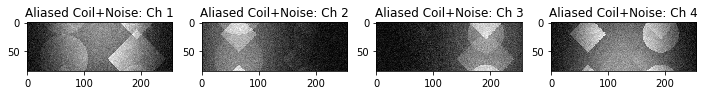

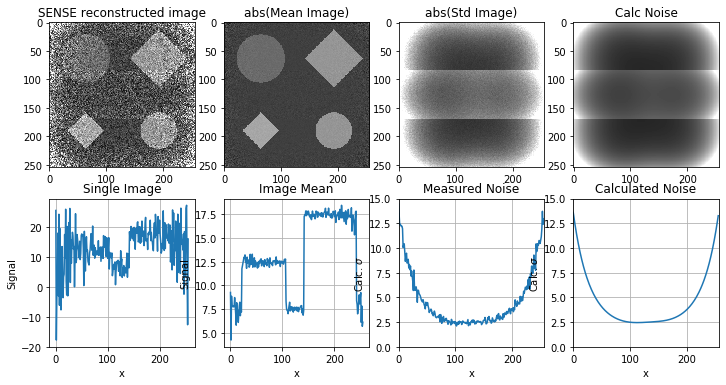

In [39]:
Nnoise = 100  # -- Number of runs to do (2D recon takes about 0.1sec)
imsall = np.zeros((Ny,Nx,Nnoise),'complex64') # -- To store multiple runs


print("Reconstructing %d images (%d x %d) with %d coils and R=%d" % (Nnoise,Nx,Ny,Nc,R))
for n in range(Nnoise):
    # -- Generate random noise
    cnoise = np.random.multivariate_normal(np.zeros(Nc),Psi,(Ny*Nx)) + 1j*np.random.multivariate_normal(np.zeros(Nc),Psi,(Ny*Nx))
    cnoise = np.reshape(cnoise,(Ny,Nx,Nc),order='F')  # Ny x Nx x Nc 

    # -- Add noise cims = cims + cnoise
    cimsrecon = cims + cnoise
    
    # -- Alias the images
    cimsrecon = np.reshape(cimsrecon,(Ny,Nx,Nc,1))   # Add R dimension
    cimsrecon = np.moveaxis(cimsrecon,(0,1,2,3),(0,2,3,1))  # Move R in with Ny
    cimsrecon = np.reshape(cimsrecon,(Ny//R,R,Nx,Nc),order='F')  # Reshape to alias
    cimsrecon = np.squeeze(np.sum(cimsrecon,axis=1))   # Sum along R dimension and Squeeze (to alias!)
        
    # -- SENSE Reconstruction of noise only!
    sensesig = mrs.senserecon(cimsrecon,W)
    #print("sensesig size",sensesig.shape)
    
    # -- Combine unaliased FOVs
    sensesig = np.moveaxis(sensesig,(0,1,2),(0,2,1))    # -- Rearrange Ny x R x Nx
    sensesig = np.reshape(sensesig,(Ny,Nx),order='F')   # -- Concatenate FOVs
    
    imsall[:,:,n] = sensesig  # -- Accumulate all images
    
# -- Calculate mean / standard deviations of repeated reconstructions
sigmean = np.mean(imsall,axis=2)
sigstd = np.std(np.real(imsall),axis=2) + 1j * np.std(np.imag(imsall),axis=2)

# -- Display output...
        
# -- Plot aliased images from last run (debug)
plt.figure(figsize=(12.,5.0))
for c in range(Nc):
    plt.subplot(2,Nc,Nc+c+1)
    plotim = np.squeeze(abs(cimsrecon[:,:,c]))
    plt.imshow(plotim,cmap='gray')
    tt = "Aliased Coil+Noise: Ch %d" % (c+1)
    plt.title(tt)

# -- Show SENSE image
plt.figure(figsize=(12.,6.0))
plt.subplot(2,4,1)
plt.imshow(np.abs(sensesig),cmap='gray',vmin=0.0,vmax=30)
plt.title('SENSE reconstructed image')

plt.subplot(2,4,2)
plt.imshow(np.abs(sigmean),cmap='gray',vmin=0.0,vmax=30)
plt.title('abs(Mean Image)')

plt.subplot(2,4,3)
plt.imshow(np.abs(sigstd),cmap='gray',vmin=0.0,vmax=15.0)
plt.title('abs(Std Image)')

plt.subplot(2,4,4)
plt.imshow(np.squeeze(calcnoise),cmap='gray',vmin=0.0,vmax=15.0)
plt.title('Calc Noise')

line2plot = Ny//4
# -- Plot lines of pixel values halfway down image.
plt.subplot(2,4,5)
plt.plot(x,np.squeeze(np.real(sensesig[line2plot,:])))
mrs.lplot('x','Signal','Single Image')

plt.subplot(2,4,6)
plt.plot(x,np.squeeze(np.real(sigmean[line2plot,:])))
mrs.lplot('x','Signal','Image Mean')

plt.subplot(2,4,7)
plt.plot(x,np.squeeze(np.real(sigstd[line2plot,:])))
mrs.lplot('x','Calc. $\sigma$','Measured Noise',ax=(0,Nx,0,15))

plt.subplot(2,4,8)
plt.plot(x,np.squeeze(calcnoise[line2plot,:]))
mrs.lplot('x','Calc. $\sigma$','Calculated Noise',ax=(0,Nx,0,15))


## Results
Aliased images for each coil have FOV reduced by $1/R$.  SENSE can unalias images, but noise is amplified, particularly in areas of low coil sensitivity (edges of image here).  The measured noise standard deviation closely matches the calculated noise.

### Notes:
